In [1]:
from EffectiveXGBoost import *
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn.objects as so

In [2]:
path_url = 'https://github.com/mattharrison/datasets/raw/master/data/kaggle-survey-2018.zip'
file_name = 'kaggle-survey-2018.zip'
dataset = 'multipleChoiceResponses.csv'

survey_df = extract_dataset(path_url, file_name, dataset)
final_df = prep_data(survey_df)

pline = pipeline.Pipeline(
    [('tweak', PrepDataTransformer()),
    ('cat', encoding.OneHotEncoder(top_categories=5, drop_last=True,
    variables=['Q1', 'Q3', 'major'])),
    ('num_impute', imputation.MeanMedianImputer(imputation_method='median',
                variables=['education', 'years_exp']))]
    )

X, y = prepX_y(survey_df, 'Q6')

sur_X_train, sur_X_test, sur_y_train, sur_y_test = (model_selection
                                    .train_test_split(X, y, 
                                                      test_size=.3, 
                                                      random_state=42, 
                                                      stratify=y)
                                                        )

X_train = pline.fit_transform(sur_X_train, sur_y_train)
X_test = pline.transform(sur_X_test)

G:\My Drive\SisengAI\AlgorithmicTrading\code_rebuilding\MattHarrison\EffectiveXGBoost\EffectiveXGBoost_MyTake\EffectiveXGBoost.py:56: DtypeWarning: Columns (0,2,8,10,21,23,24,25,26,27,28,44,56,64,83,85,87,107,109,123,125,150,157,172,174,194,210,218,219,223,246,249,262,264,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,304,306,325,326,329,341,368,371,384,385,389,390,391,393,394) have mixed types. Specify dtype option on import or set low_memory=False.
  all_df = pd.read_csv(z.open(dataset))


In [3]:
stump_dt = tree.DecisionTreeClassifier(max_depth=1)
X_train = pline.fit_transform(sur_X_train)
stump_dt.fit(X_train, sur_y_train)

DecisionTreeClassifier(max_depth=1)

In [4]:
X_test = pline.transform(sur_X_test)
stump_dt.score(X_test, sur_y_test)

0.6243093922651933

## 7.1 Decision Tree Hyperparameters
For models based off of scikit-learn, a general rule to consider is that hyperparameters that start with `"max_"` will make the model
more complex when you raise it (and simpler when you reduce); and, those hyperparameters that start with `"min_"` will make the
model simpler if you raise then ( and more complex when you reduce them).

For scikit-learn's DecisionTreeClassifier, the hyperparameters and their default values include:

* `"max_depth=None"` -  The maximum depth of the tree. The default value is to keep splitting until all nodes are pure or
there are fewer than the values in `"min_samples_split"` samples in each node. Range is from 1 to any large number.
* `"max_features=None"` - Amount of features to examine for the split. Default is the number
of features. Range is from 1 to any number of features.
* `"max_leaf_node=None"` - Number of leaves in a tree. Range is from 1 to any large number.
* `"min_impurity_decrease=0"` - Split when impurity is `>=` this value. (Impurity : 0 - 100%
accurate, .3 - 70%). Range is values from 0.0 to 1.0
* `"min_samples_leaf=1"`, - Minimum samples at each leaf. Range is from 1 to a large number.
* `"min_samples_split=2"` - Minimum samples required to split a node. Range is from 2 to a large number.
* `"min_weight_fraction_leaf=0"` - The fraction of the total weights required to be a leaf. Range is from 1 to a large number.

Starting from the begining, you instantiate the class `DecisionTreeClassifier` from scikit-learn.
```python
tree.DecisionTreeClassifier(max_depth=1)
```
Then we pass in the values we want for any of the hyperparameters we are interested in the constructor og the class as an argument (in the above we only pass in `"max_depth=1"`).

We are going to explore the parameters of our trained model using the `.get_params` method:

In [6]:
stump_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

We can see here that from the output that our `max_depth = 1` just like we defined.

## 7.2 Tracking changes with Validation Curves

We are going to plot a chart that tracks the accuracy as we adjust the depth of the tree.

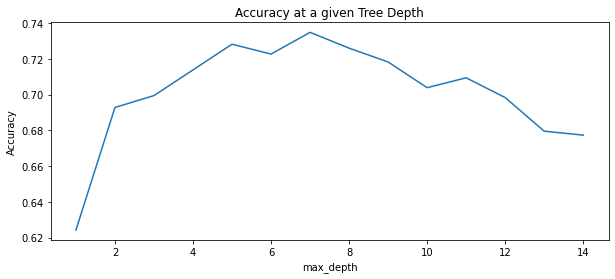

In [8]:
accuracies = []
for depth in range(1, 15):
    between = tree.DecisionTreeClassifier(max_depth=depth)
    between.fit(X_train, sur_y_train)
    accuracies.append(between.score(X_test, sur_y_test))
fig, ax = plt.subplots(figsize=(10,4))
(pd.Series(accuracies, name='Accuracy', index=range(1, len(accuracies)+1))
.plot(ax=ax, title='Accuracy at a given Tree Depth'))
ax.set_ylabel('Accuracy')
ax.set_xlabel('max_depth');

From the graph above, at the point where the accuracy begins to fall is the tree_depth value where the model starts to overfit. The model is not extracting any more meaningful insights from the training data to enable it generalize on data it hasn't seen (the test data we fed into it after training).

From eyeballing the graph, we can see that it seems to taper off when the `max_depth = 7`. We will use the `.score` method to verify. But before we do that, we will:
1. re-instatiate the `DecisionTreeClassifier` class from scikit-learn's `tree` module, and pass in `"max_depth=7"` in the constructor as an argument, 
2. use the `.fit` method to train it then pull out the accuracy of the model on our test set.

In [9]:
between = tree.DecisionTreeClassifier(max_depth=7)
between.fit(X_train, sur_y_train)
between.score(X_test, sur_y_test)

0.7348066298342542

## 7.3 Leveraging Yellowbrick
The Yellowbrick library provides a visualizer,
`validation_curve`, for us to use with the help of matplotlib. Here are the arguments to be passed into the `validation_curve` method:
* `DecisionTreeClassifier` class 
* `X` is the feature matrix of the data (the training and test set to be concatenated)
* `y` is the target vector of the data (the training and test set to be concatenated)
* `param_name='max_depth'`, specifies the name of the hyperparameter to vary. In this case, it is set to `'max_depth'`.
* `param_range=range(1,14)`, specifies the range of values to try for the hyperparameter. In this case, it is set to a range of values from 1 to 13.
* `scoring='accuracy'`, this takes in a scikit-learn model metric string or function that specifies the performance metric to use. In our case, we chose 'accuracy'.
* `cv=5`, specifies the number of cross-validation folds to use. The default value is 3 but in our case we set it to 5.
* `ax`, specifies the matplotlib axes object on which to plot the validation curve. This is defined with the code: `fig, ax = plt.subplots(figsize=(10,4))`
* `n_jobs=6`, specifies the number of CPU cores to use for parallel computation, set to 6 in our case.

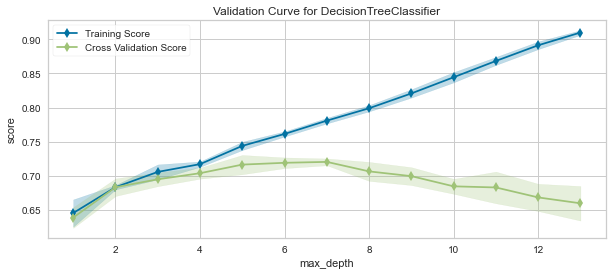

In [11]:
from yellowbrick.model_selection import validation_curve

fig, ax = plt.subplots(figsize=(10,4))

viz = validation_curve(tree.DecisionTreeClassifier(),
    X=pd.concat([X_train, X_test]),
    y=pd.concat([sur_y_train, sur_y_test]),
    param_name='max_depth', param_range=range(1,14),
    scoring='accuracy', cv=5, ax=ax, n_jobs=6)


The two lines on the chart above shows the tracking of the "training score" (which is the accuracy of the training data) and the "cross validation score", ie  the accuracy of the testing data, which is what we should care about in this instance since it tells us how well the model generalizes (ie how it behaves on data it hasn't seen before). The testing data score drops as our model begins to
overfit. This plot validates our test and suggests that a depth of 7 is an appropriate choice.

We can also notice that each plot has some shaded region. They represent the standard deviation of the scores across the cross-validation folds. This gives an indication of how much variability there is in the model’s performance across different splits of the data. A wide shaded region indicates that there is a lot of variability in the model’s performance, while a narrow shaded region indicates that the model’s performance is more consistent across different splits of the data.

Ideally, we want to choose a value that results in high test scores and low variability in performance (narrow shaded regions).


## 7.4 Grid Search
Since the above only tracks performance on a single hyperparameter, we will want one that does so across all the given spectrum of hyperparameters available. Grid search is one technique used to find the best hyperparameters for a model by training
the model on different combinations of hyperparameters and evaluating its performance
on a validation set. When used in decision tree models, it tunes the
hyperparameters that control the tree’s growth, such as the maximum depth, minimum
samples per leaf, and minimum samples per split. A list of possible values for each hyperparameter is specified, and the
model is trained and evaluated on every combination of different hyperparameters. Afterwards, the
combination that produces the best performance on the validation set is selected as the optimal
set of hyperparameters for the model.

From scikit-learn's `GridSearchCV` class, we can specify a dictionary to map the hyperparameters we have chosen to explore to a list of options.

* We first of all define a dictionary of hyperparameters and their possible values and assign that to the variable "params". In this case, the hyperparameters being varied are `max_depth`, `min_samples_leaf`, and `min_samples_split`. The values for each hyperparameter are specified as lists.
* An instance of the `GridSearchCV` class is created. The first argument to the constructor is an instance of the `DecisionTreeClassifier` class. The second argument, `param_grid`, specifies the dictionary of hyperparameters and their possible values. The third argument, `cv`, specifies the number of cross-validation folds to use. while the fourth argumant, `n_jobs`, specifies the number of CPU cores to use for parallel computation. The fifth argument, `verbose`, controls the verbosity of the output. The sixth argument, `scoring`, specifies the performance metric to use.
* After creating the `GridSearchCV` object, its `.fit` method is called to perform the grid search. The first argument to this method is the feature matrix for the data, which is created by concatenating the training and test sets for `'X'`. The second argument is the target vector for the data, which is created by concatenating the training and test sets for `'y'`.

In [13]:
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': [3, 5, 7, 8],
    'min_samples_leaf': [1, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5, 6],
}
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(),
        param_grid=params, cv=4, n_jobs=-1,
        verbose=1, scoring="accuracy")
grid_search.fit(pd.concat([X_train, X_test]),
    pd.concat([sur_y_train, sur_y_test]))

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8],
                         'min_samples_leaf': [1, 3, 4, 5, 6],
                         'min_samples_split': [2, 3, 4, 5, 6]},
             scoring='accuracy', verbose=1)

Now that the grid search is complete, we can access the results using attributes of the `GridSearchCV` object such as `best_params_` and `best_score_`.

In [14]:
grid_search.best_params_

{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [15]:
grid_search.best_score_

0.7190715475850797

In [16]:
gscv = tree.DecisionTreeClassifier(**grid_search.best_params_)
gscv.fit(X_train, sur_y_train)
gscv.score(X_test, sur_y_test)

0.7259668508287292

The `** `operator is used to unpack a dictionary of key-value pairs into keyword arguments when calling a function. This allows you to pass the contents of a dictionary as separate keyword arguments to a function, in our case the best params gotten from our grid search.

There is also a `.cv_results_` attribute that contains the scores for each of the options. Let us visualize what it tells us using _pandas_.

In [17]:
(pd.DataFrame(grid_search.cv_results_)
.sort_values(by='rank_test_score')
.style
.background_gradient(axis='rows')
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
65,0.014293,0.000719,0.006006,0.000703,7,5,2,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 2}",0.706897,0.737401,0.712202,0.719788,0.719072,0.011531,1
68,0.013882,0.001245,0.005750,0.000434,7,5,5,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 5}",0.706897,0.740053,0.712202,0.715803,0.718739,0.012707,2
69,0.014547,0.002606,0.007752,0.002774,7,5,6,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 6}",0.705570,0.740053,0.709549,0.715803,0.717744,0.013387,3
66,0.014127,0.001138,0.005505,0.000500,7,5,3,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 3}",0.706897,0.737401,0.709549,0.715803,0.717412,0.011985,4
67,0.017294,0.005617,0.005755,0.000833,7,5,4,"{'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 4}",0.706897,0.737401,0.709549,0.715803,0.717412,0.011985,4
74,0.014132,0.001242,0.005537,0.001490,7,6,6,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 6}",0.708223,0.738727,0.705570,0.715803,0.717081,0.013049,6
72,0.014253,0.000437,0.005294,0.000574,7,6,4,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 4}",0.708223,0.738727,0.705570,0.715803,0.717081,0.013049,6
70,0.014131,0.000742,0.005500,0.000501,7,6,2,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}",0.706897,0.738727,0.705570,0.715803,0.716749,0.013285,8
62,0.015006,0.002918,0.005127,0.000220,7,4,4,"{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 4}",0.708223,0.734748,0.709549,0.714475,0.716749,0.010650,9
73,0.020255,0.010253,0.005376,0.000416,7,6,5,"{'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 5}",0.706897,0.738727,0.705570,0.714475,0.716417,0.013321,10


The darker cells in each column have better scores. 

We can manually validate the results of the grid search using the `cross_val_score`. This
scikit-learn function does cross validation on the model and returns the score from each
training.

In [18]:
results = model_selection.cross_val_score(
    tree.DecisionTreeClassifier(max_depth=7),
    X=pd.concat([X_train, X_test], axis='index'),
    y=pd.concat([sur_y_train, sur_y_test], axis='index'),
    cv=4
)

results

array([0.69628647, 0.73740053, 0.70159151, 0.7184595 ])

In [19]:
results.mean()

0.7134345024851962

Here is the same process running against the updated hyperparameters from the grid
search.

In [22]:
results = model_selection.cross_val_score(
    tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=5,
     min_samples_split=2),
    X=pd.concat([X_train, X_test], axis='index'),
    y=pd.concat([sur_y_train, sur_y_test], axis='index'),
    cv=4
)
print(results)
results.mean()

[0.70557029 0.74005305 0.71220159 0.71580345]


0.718407096635562